<a href="https://colab.research.google.com/github/theeanalyst/sentiment_analysis/blob/main/Bert_base_uncased_model_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the datasets library
!pip install transformers
!pip install datasets
!pip install sentencepiece
!pip install transformers datasets
!pip install transformers[torch]
!pip install accelerate
!pip install accelerate>=0.20.1
!pip install huggingface_hub
!pip install  -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.2 MB/s eta 0:00:00


In [2]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import numpy as np
from datasets import load_metric
import nltk
from nltk.corpus import stopwords
from datasets import load_dataset

import transformers
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig, AdamW
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import mean_squared_error
from huggingface_hub import notebook_login
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
notebook_login()

In [5]:
# Load the dataset and display some values
df_train = pd.read_csv('/content/drive/MyDrive/Train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Test.csv')


In [6]:
df_train.info(),df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


(None, None)

In [7]:
df_train.isna().sum(),df_test.isna().sum()

(tweet_id     0
 safe_text    0
 label        1
 agreement    2
 dtype: int64,
 tweet_id     0
 safe_text    1
 dtype: int64)

In [8]:
# A way to eliminate rows containing NaN values
df_train = df_train[~df_train.isna().any(axis=1)]
df_test = df_test[~df_test.isna().any(axis=1)]

In [13]:
df_train.isna().sum(),df_test.isna().sum()

(tweet_id     0
 safe_text    0
 label        0
 agreement    0
 dtype: int64,
 tweet_id     0
 safe_text    0
 dtype: int64)

In [14]:
# Set the max_colwidth option to a higher value
pd.set_option('display.max_colwidth', None)

In [15]:
df_train.head(5)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.0
3,1DR6ROZ4,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0,1.0


In [16]:
df_test.head(5)

,tweet_id,safe_text
0,00BHHHP1,"<user> <user> ... &amp; 4 a vaccine given 2 healthy peeps, FDA think just not worth the AE risk unfortunately."
1,00UNMD0E,Students starting school without whooping cough vaccinations <url> #scpick
2,01AXPTJF,"I'm kinda over every ep of <user> being ""ripped from the headlines."" Measles? Let's get back to crime. #SVU"
3,01HOEQJW,How many innocent children die for lack of vaccination each year? Around 1.5 million. Too bad all their parents couldn't be here. #SB277
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though risk is low: Federal officials said Wednesday they're taking steps… <url>"


# **Exploratory Data Analysis(EDA)**

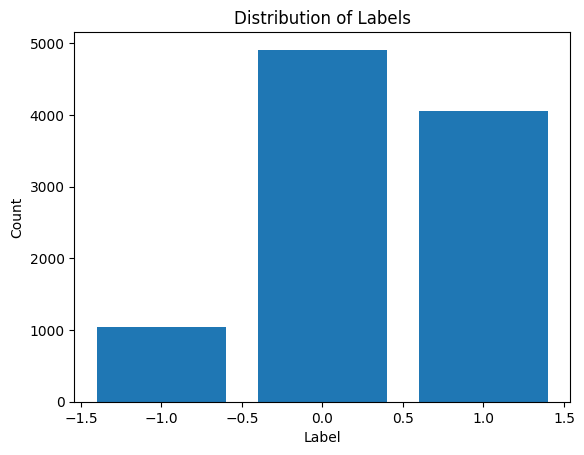

In [17]:

# Plot the distribution of labels
label_counts = df_train['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

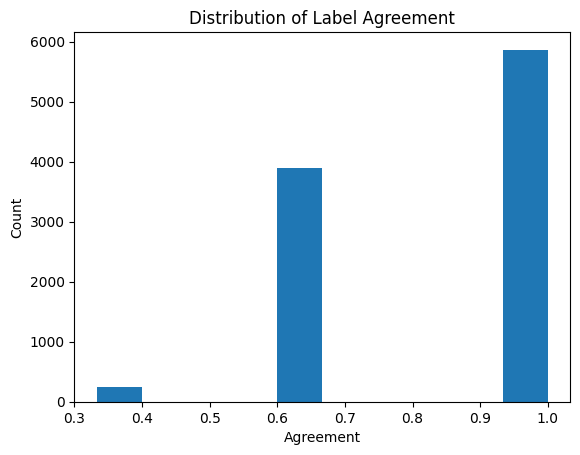

In [18]:
# Plot the distribution of 'agreement'
plt.hist(df_train['agreement'])
plt.xlabel('Agreement')
plt.ylabel('Count')
plt.title('Distribution of Label Agreement')
plt.show()

In [19]:
# Calculate the correlation between 'label' and 'agreement'
correlation = df_train['label'].corr(df_train['agreement'])

# Print the correlation value
print(f"Correlation: {correlation}")

Correlation: 0.13815479087588003


Data Cleaning
Issues:

Remove unneccesary columns.
Remove emojis and other characters from safe text column.
Remove punctuations from the safe tect column
Changing all text to lower cases.

In [20]:
# Remove unnecessary columns
df_train = df_train.drop(['tweet_id'], axis=1)
df_test = df_test.drop(['tweet_id'], axis=1)

In [21]:

# Clean the 'safe_text' column (example: remove URLs and special characters)
df_train['safe_text'] = df_train['safe_text'].str.replace(r'', '')  # Remove  tag
df_test['safe_text'] = df_test['safe_text'].str.replace(r'', '')  # Remove  tag

# Remove emojis and other special characters
emojis = re.compile(r'[^\w\s@#$%^*()<>/|}{~:]')
df_train["safe_text"] = df_train["safe_text"].str.replace(emojis, '')
df_test["safe_text"] = df_test["safe_text"].str.replace(emojis, '')

# # Remove punctuation
punctuation = string.punctuation
df_train["safe_text"] = df_train["safe_text"].str.translate(str.maketrans('', '', punctuation))
df_test["safe_text"] = df_test["safe_text"].str.translate(str.maketrans('', '', punctuation))

In [22]:
# Turn the safe_text column into lowercase
df_train["safe_text"] = df_train["safe_text"].str.lower()
df_test["safe_text"] = df_test["safe_text"].str.lower()

In [23]:

from collections import Counter

# Concatenate all the 'safe_text' into a single string
text = ' '.join(df_train['safe_text'])

# Split the text into words
words = text.split()

# Count the frequency of each word
word_counts = Counter(words)

# Display the most common words
print(word_counts.most_common(10))

[('user', 5494), ('url', 4630), ('the', 4118), ('to', 3636), ('measles', 3512), ('a', 2453), ('of', 2354), ('in', 2174), ('and', 1993), ('i', 1705)]


The list will contain the ten most common words in the 'safe_text' column of the df_train DataFrame, along with their frequencies.

In [24]:
# Download the stop words (only required for the first time)
nltk.download('stopwords')

# Remove stop words
stop_words = set(stopwords.words('english'))
df_train['safe_text'] = df_train['safe_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


This preprocessing step is often performed to clean and prepare text data for natural language processing tasks like sentiment analysis, text classification, and more.

In [25]:
df_test['safe_text'] = df_test['safe_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [26]:
# Save df_train
df_train.to_csv('df_train.csv', index=False)

# Save df_test
df_test.to_csv('df_test.csv', index=False)

Import Cleaned Data

In [27]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [28]:
# Load the dataset and display some values
df = pd.read_csv('/content/df_train.csv')

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

Data Spliting

In [29]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [30]:
eval.head()

,safe_text,label,agreement
6569,childrens museum houston offer free vaccinations url,1.0,1.000000
1754,user properly immunized prior performance kid puts legit show say,1.0,1.000000
3325,user thx posting vaccinations imperative dear puppy know died parvo terrible death humans wise,1.0,1.000000
1485,baby exactly everyone needs vaccinate url via user,1.0,0.666667
4175,meeting tonight 830pm room 322 student center kent ksu kentstate immunizations childrenfirst url,1.0,1.000000


In [31]:
train.head()

,safe_text,label,agreement
9303,mickeys measles gone international url,0.0,1.000000
3907,s1256 new extends exemption charitable immunity certain civil actions persons age url,0.0,1.000000
795,user ignorance vaccines isnt dangerous innocent child others around shame,1.0,0.666667
5791,pakistan partly suspends polio vaccination program terrorists kill health workers url,0.0,1.000000
3431,news ive gone like 1000 mmr,0.0,1.000000


Saving the two datas

In [32]:
# Create the data directory
if not os.path.exists("../data"):
    os.makedirs("../data")

# Save splitted subsets
train.to_csv("../data/train_subset.csv", index=False)
eval.to_csv("../data/eval_subset.csv", index=False)

In [33]:
# Load the dataset from CSV files
dataset = load_dataset('csv',
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           data_files={'train': '../data/train_subset.csv',
                        'eval': '../data/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

### Transformers and Tokenization

In [34]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Import the tokenizer from transformers library
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [35]:
# Function to transform labels
def transform_labels(label):
    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

# Function to tokenize data
def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [36]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
# Training Arguments
training_args = TrainingArguments(
    output_dir="mytuned_test_trainer-cardiffnlp/twitter-xlm-roberta-base-sentiment",
    num_train_epochs=10,
    load_best_model_at_end=True,
    save_strategy="epoch",
    push_to_hub=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=100,
    per_device_train_batch_size=16,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Loading Pre-Trained Model

In [37]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuningcardiffnlp/twitter-xlm-roberta-base-sentiment
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Splitting Train Set

In [38]:
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

Evaluation Metric

In [39]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"rmse": mean_squared_error(labels, predictions, squared=False)}

Model Training Setup

In [43]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
# Training Arguments
training_args = TrainingArguments(
    output_dir="tuned_test_trainer-bert-base-uncased",
    num_train_epochs=5,
    load_best_model_at_end=True,
    save_strategy="epoch",
    push_to_hub=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=100,
    per_device_train_batch_size=16,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [44]:
# Model Training Setup
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [45]:

# Launch the learning process: training
trainer.train()

Epoch,Training Loss,Validation Loss,Rmse
1,0.702100,0.622225,0.667458
2,0.546100,0.630470,0.696060
3,0.353000,0.730651,0.662948
4,0.201400,1.005451,0.675278
5,0.110600,1.297622,0.683740


TrainOutput(global_step=2500, training_loss=0.38266490936279296, metrics={'train_runtime': 3968.1815, 'train_samples_per_second': 10.079, 'train_steps_per_second': 0.63, 'total_flos': 1.052322114203136e+16, 'train_loss': 0.38266490936279296, 'epoch': 5.0})

In [46]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer.evaluate()

<ipython-input-46-756a1fc1737c>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


{'eval_loss': 0.6222251057624817,
 'eval_rmse': 0.6674578638386097,
 'eval_runtime': 60.8488,
 'eval_samples_per_second': 32.868,
 'eval_steps_per_second': 4.109,
 'epoch': 5.0}

In [47]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1699459735.f6b843196e2b.1084.2:   0%|          | 0.00/407 [00:00<?, ?B/s]

events.out.tfevents.1699454965.f6b843196e2b.1084.1:   0%|          | 0.00/7.20k [00:00<?, ?B/s]

'https://huggingface.co/Theeanalyst/tuned_test_trainer-bert-base-uncased/tree/main/'